In [133]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [134]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [135]:
#seperate test from train

nba_train = nba[nba.test == 0]
nba_test = nba[nba.test ==1]  #scott tarlow scotttarlow@gmail.com
#learn a domain

In [136]:
nba_train = nba_train[nba_train.playoff_game == 1]
nba_test = nba_test[nba_test.playoff_game == 1]

In [137]:

X_train = nba_train.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'         ])


#X = nba[features]
y_train = nba_train['cover']

In [138]:
X_test= nba_test.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff',       ])

y_test = nba_test.away_cover

In [139]:

X_test.shape

(150, 126)

In [140]:
X_train.shape

(711, 126)

In [141]:

# #create interactions  tested but did not help the model
# poly = PolynomialFeatures(degree = 2, interaction_only= True)
# X_poly = poly.fit_transform(X_train)
# X_poly_test = poly.transform(X_test)
# X_poly = pd.DataFrame(X_poly, 
#                       columns = poly.get_feature_names(X_train.columns))
# X_poly_test = pd.DataFrame(X_poly_test, 
#                            columns = poly.get_feature_names(X_test.columns))


In [142]:

#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [143]:
from sklearn.decomposition import PCA

In [144]:
pc = PCA(n_components=80)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [145]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.12516624 0.11211871 0.06562074 0.04696526 0.04225086 0.03914961
 0.03589683 0.0335322  0.0330731  0.02887377 0.02826089 0.02606838
 0.02466281 0.0202689  0.01855282 0.01807258 0.01737527 0.01555985
 0.01482064 0.01389915 0.01367511 0.01275023 0.0113291  0.01105182
 0.01027463 0.00958681 0.00919624 0.00880109 0.00852177 0.00801577
 0.00762347 0.00736163 0.00663125 0.00638194 0.0061221  0.00558273
 0.00555084 0.00516962 0.00490417 0.00443793 0.00433656 0.00412803
 0.00393973 0.0035874  0.00349444 0.00333675 0.00314843 0.00295742
 0.00290552 0.00271631 0.00262093 0.0024927  0.00229733 0.0021585
 0.00208578 0.0019955  0.00195832 0.0017789  0.00171916 0.0016916
 0.001466   0.00144012 0.00137015 0.00123623 0.00116705 0.00112485
 0.00105784 0.00104258 0.00102522 0.00094303 0.00087334 0.00084813
 0.00079926 0.00077858 0.00071252 0.0006775  0.00061175 0.00051285
 0.00041875 0.00038991]
Cumulative explained variance:  [0.12516624 0.23728495 0.30290569 0.3498709

### Logistic Regression

The first model I tested out was the logistic regression 

In [146]:
lr = LogisticRegressionCV(Cs=[  100000  ] , 
                          max_iter=10000,
                          tol = .001,
                          scoring='precision',
                          penalty='l2', 
                          solver ='saga', 
                          cv =5 )
lr.fit(X_train_pc, y_train)
lr.score(X_train_pc, y_train)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.6634146341463415

In [147]:
lr.score(X_test_pc, y_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.576271186440678

In [148]:
y_hat_lr = lr.predict(X_train_pc)
y_hat_lrp = lr.predict_proba(X_train_pc)
y_hat_lrt = lr.predict(X_test_pc)

In [149]:
print(classification_report(y_train, y_hat_lr))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       333
           1       0.66      0.72      0.69       378

   micro avg       0.66      0.66      0.66       711
   macro avg       0.66      0.65      0.65       711
weighted avg       0.66      0.66      0.66       711



In [150]:
confusion_matrix( y_train, y_hat_lr)

array([[195, 138],
       [106, 272]])

In [151]:
confusion_matrix( y_test, y_hat_lrt)

array([[48, 25],
       [43, 34]])

### Support Vector Machine

The second model I tested is the Support Vector Machine Model I 

In [152]:
svc = SVC(probability=True)
svc_params = {
    'kernel' : ['linear'  ], 
    'C'      : [.4, .5, .3]
    }

In [153]:
gs = GridSearchCV(svc, 
                  param_grid=svc_params, 
                  scoring='precision', 
                  cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5569536038617146
{'C': 0.3, 'kernel': 'linear'}


In [154]:
gs.score(X_test_pc, y_test)

0.5454545454545454

In [155]:
y_hat_svc = gs.predict(X_train_pc)
y_hat_svcp = gs.predict_proba(X_train_pc)
y_hat_svct = gs.predict(X_test_pc)

In [156]:
print(classification_report(y_train, y_hat_svc))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       333
           1       0.65      0.73      0.69       378

   micro avg       0.65      0.65      0.65       711
   macro avg       0.65      0.65      0.65       711
weighted avg       0.65      0.65      0.65       711



In [157]:
confusion_matrix( y_train, y_hat_svc)

array([[186, 147],
       [101, 277]])

In [158]:
confusion_matrix( y_test, y_hat_svct)

array([[43, 30],
       [41, 36]])

### Neural Network

In [159]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

In [160]:
model = Sequential()
model.add(Dense(70, 
                activation = 'relu',
                input_dim = X_train_pc.shape[1],
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [161]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_pc, 
          y_train, epochs =15, 
          batch_size= 128, 
          validation_data=(X_test_pc, y_test))

Train on 711 samples, validate on 150 samples
Epoch 1/15
711/711 [==============================] - 1s 912us/step - loss: 2.0333 - acc: 0.4571 - val_loss: 1.8293 - val_acc: 0.4733
Epoch 2/15
711/711 [==============================] - 0s 23us/step - loss: 1.9080 - acc: 0.4782 - val_loss: 1.6937 - val_acc: 0.4867
Epoch 3/15
711/711 [==============================] - 0s 24us/step - loss: 1.7740 - acc: 0.4965 - val_loss: 1.5757 - val_acc: 0.4933
Epoch 4/15
711/711 [==============================] - 0s 24us/step - loss: 1.6885 - acc: 0.4937 - val_loss: 1.4806 - val_acc: 0.5133
Epoch 5/15
711/711 [==============================] - 0s 23us/step - loss: 1.6079 - acc: 0.4937 - val_loss: 1.4072 - val_acc: 0.5133
Epoch 6/15
711/711 [==============================] - 0s 24us/step - loss: 1.4859 - acc: 0.5274 - val_loss: 1.3518 - val_acc: 0.5333
Epoch 7/15
711/711 [==============================] - 0s 24us/step - loss: 1.4519 - acc: 0.5063 - val_loss: 1.3092 - val_acc: 0.5400
Epoch 8/15
711/711 [==

In [162]:
y_hat_nn = model.predict(X_train_pc)
y_hat_nnp = model.predict_proba(X_train_pc)

In [163]:
y_hat_nnp

array([[0.3877135 ],
       [0.46229407],
       [0.7450822 ],
       [0.52712166],
       [0.40380841],
       [0.63601077],
       [0.62945706],
       [0.51109535],
       [0.32619336],
       [0.368478  ],
       [0.60637355],
       [0.5663985 ],
       [0.42625862],
       [0.56440854],
       [0.7577236 ],
       [0.70322716],
       [0.61817497],
       [0.7534342 ],
       [0.36378917],
       [0.30326644],
       [0.45972946],
       [0.36861184],
       [0.3974966 ],
       [0.32171425],
       [0.42503527],
       [0.4228787 ],
       [0.67985094],
       [0.7392366 ],
       [0.58693403],
       [0.41517338],
       [0.554958  ],
       [0.6797381 ],
       [0.62157214],
       [0.63832843],
       [0.5348606 ],
       [0.685529  ],
       [0.45066455],
       [0.5270019 ],
       [0.6072458 ],
       [0.5134937 ],
       [0.52752584],
       [0.49239704],
       [0.42843232],
       [0.47170356],
       [0.6070025 ],
       [0.5062667 ],
       [0.31890455],
       [0.368

In [164]:
rf = RandomForestClassifier()
rf_params = {'n_estimators'      : [200, 150],
             'max_depth'         : [80,90],
             'min_samples_split' : [200,210]}

gs = GridSearchCV(rf, 
                  param_grid=rf_params,
                  scoring='precision',
                 cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)



0.5354917264650206
{'max_depth': 80, 'min_samples_split': 200, 'n_estimators': 200}


In [165]:
gs.score(X_test_pc, y_test)

0.5603448275862069

In [166]:
y_hat_rf = gs.predict(X_train_pc)
y_hat_rfp = gs.predict_proba(X_train_pc)

In [167]:
y_hat_rft = gs.predict(X_test_pc)

In [168]:
print(classification_report(y_test, y_hat_rft))

              precision    recall  f1-score   support

           0       0.65      0.30      0.41        73
           1       0.56      0.84      0.67        77

   micro avg       0.58      0.58      0.58       150
   macro avg       0.60      0.57      0.54       150
weighted avg       0.60      0.58      0.55       150



In [169]:
confusion_matrix( y_train, y_hat_rf)

array([[164, 169],
       [  6, 372]])

In [170]:
confusion_matrix( y_test, y_hat_rft)

array([[22, 51],
       [12, 65]])

In [171]:
# import xgboost as xgb
# # read in data
# dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)

In [172]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
nba_train.loc[:, 'actual_y'] = y_train
nba_train.loc[:, 'predicted_label_rf'] = y_hat_rf
nba_train.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#Bayesian

nba_train.loc[:, 'predicted_label_svc'] = y_hat_svc
nba_train.loc[:, 'predicted_proba_svcp'] = y_hat_svcp[:, 1]

nba_train.loc[:, 'predicted_label_lr'] = y_hat_lr
nba_train.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]

In [173]:
from sklearn.metrics import roc_curve, auc

In [174]:
fpr, tpr, _ = roc_curve(y_train, nba_train['predicted_proba_lrp'])
roc_auc = auc(fpr, tpr)

In [175]:
fpr1, tpr1, _ = roc_curve(y_train, nba_train['predicted_proba_rfp'])
roc_auc1 = auc(fpr1, tpr1)

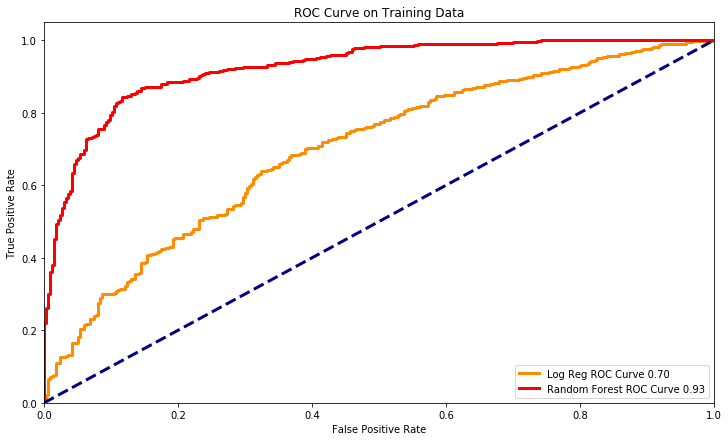

In [176]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", 
         label = "Log Reg ROC Curve %.2f" % roc_auc)
plt.plot(fpr1, tpr1, lw = line_width, color="red", 
         label = "Random Forest ROC Curve %.2f" % roc_auc1)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc="lower right")
plt.show()

In [177]:
for prob in range(40, 65, 1):
    proba = prob/100
    
    nba_train.loc[:, 'predicted_label']= nba_train['predicted_proba_rfp'].map(
    lambda p: 1 if p > proba else 0)
    
#     X_train.loc[:, 'predicted_label']= X_train['predicted_proba_rfp'].map(
#     lambda p: 1 if p > proba else 0)
    
#    results = X_test[X_test['predicted_label']==1]
    print('Test  ' + str(proba))
#     print (confusion_matrix(y_test, nba['predicted_label']))
    results_neg = nba_train[nba_train['predicted_label']==1]
    print ("Return of Home Games: ", results_neg.home_payout.sum())
#     print(' Train  ' + str(proba))
#     print(confusion_matrix(y_train, X_train['predicted_label']))

Test  0.4
Return of Home Games:  24.60199999999999
Test  0.41
Return of Home Games:  24.60199999999999
Test  0.42
Return of Home Games:  24.60199999999999
Test  0.43
Return of Home Games:  24.60199999999999
Test  0.44
Return of Home Games:  25.60199999999999
Test  0.45
Return of Home Games:  27.60199999999999
Test  0.46
Return of Home Games:  38.60199999999999
Test  0.47
Return of Home Games:  58.60199999999999
Test  0.48
Return of Home Games:  84.60199999999998
Test  0.49
Return of Home Games:  128.96599999999998
Test  0.5
Return of Home Games:  175.148
Test  0.51
Return of Home Games:  205.786
Test  0.52
Return of Home Games:  235.78699999999998
Test  0.53
Return of Home Games:  250.516
Test  0.54
Return of Home Games:  234.974
Test  0.55
Return of Home Games:  195.16100000000006
Test  0.56
Return of Home Games:  136.804
Test  0.57
Return of Home Games:  98.89900000000002
Test  0.58
Return of Home Games:  54.53999999999999
Test  0.59
Return of Home Games:  29.088
Test  0.6
Return of 

In [178]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.feature_importances_

feature_scores = pd.DataFrame(rf.feature_importances_,
                            index = X_train.columns,
                            columns=['Feature Scores']).sort_values(
                            'Feature Scores',ascending=False)

feature_scores

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Feature Scores
mov_5_line_cv,0.021103
mov_5_away_assists,0.021038
mov_5_away_def_eff,0.019567
away_win_pct,0.017376
mov_5_home_win_margin,0.016053
last_or,0.015814
lastaway_score,0.015733
mov_5_away_spread,0.015598
mov_5_pts,0.015485
mov_5_away_pace,0.015432


In [179]:
rf.score(X_train, y_train)

0.9831223628691983

In [180]:
rf.score(X_test, y_test)

0.5066666666666667